# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Helping Functions

In [3]:
def print_unique(col):
    """
    Prints the unique values in a column and their count.

    Args:
        col (series): a specific column from a data frame.
    """
    temp = col.unique()
    temp.sort()
    print(temp)
    
    temp_count = col.value_counts().sort_values(ascending=False)
    print(temp_count)
    
    
    
def identify_categories(data):
    """
    Finds the categorical features (columns) in a data frame.

    Args:
        data (Data Frame): Training Data.
    """
    cat_cols = [cname for cname in data.columns if
                    data[cname].dtype == "object"]
    
    return cat_cols

# Loading and Inspecting The Data

In [4]:
train_data_path = "/home/youssouf/Desktop/GitHub_Repos/BigMart-Product-Outlet-Sales-Analysis-and-Prediction/Data/Train.csv"
test_data_path = "/home/youssouf/Desktop/GitHub_Repos/BigMart-Product-Outlet-Sales-Analysis-and-Prediction/Data/Test.csv"

bigmart_data = pd.read_csv(train_data_path)
bigmart_test_data = pd.read_csv(test_data_path)

# Training data inspection
print("Shape of the training data: ", bigmart_data.shape)
print("- " * 70)

print(bigmart_data.info())
print(bigmart_test_data.info())
print("- " * 70)

bigmart_data.head()

Shape of the training data:  (8523, 12)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

# Detecting Missing Values

Item_Weight    1463
Outlet_Size    2410
dtype: int64
Item_Weight     976
Outlet_Size    1606
dtype: int64


<AxesSubplot: >

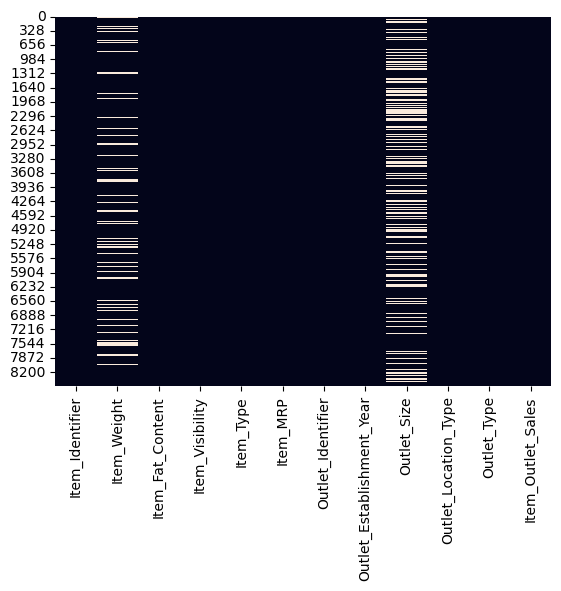

In [5]:
# Using isnull()
missing_val_count = (bigmart_data.isnull().sum())
print(missing_val_count[missing_val_count > 0])

missing_val_count = (bigmart_test_data.isnull().sum())
print(missing_val_count[missing_val_count > 0])

# Using sns heatmap
sns.heatmap(bigmart_data.isnull(), cbar = False)
# sns.heatmap(bigmart_test_data.isnull(), cbar=False)

## Filling `NULL` Values

In [6]:
# Filling the missing Values
bigmart_data['Item_Weight'].fillna(bigmart_data['Item_Weight'].mode()[0],inplace=True)
bigmart_data['Outlet_Size'].fillna(bigmart_data['Outlet_Size'].mode()[0],inplace=True)

bigmart_test_data['Item_Weight'].fillna(bigmart_test_data['Item_Weight'].mode()[0],inplace=True)
bigmart_test_data['Outlet_Size'].fillna(bigmart_test_data['Outlet_Size'].mode()[0],inplace=True)

# Using sns heatmap
sns.heatmap(bigmart_data.isnull(), cbar = False)

<AxesSubplot: >

# Determining Categorical Features

In [7]:
print(identify_categories(bigmart_data))

['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [8]:
# Uniqueness Check
numerical_cols = [cname for cname in bigmart_data.columns if bigmart_data[cname].dtype in ['float64']]
categorical_cols = identify_categories(bigmart_data)

for cat in categorical_cols:
    print_unique(bigmart_data[cat])

['DRA12' 'DRA24' 'DRA59' ... 'NCZ42' 'NCZ53' 'NCZ54']
FDW13    10
FDG33    10
NCL31     9
DRN47     9
FDO19     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64
['LF' 'Low Fat' 'Regular' 'low fat' 'reg']
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
['Baking Goods' 'Breads' 'Breakfast' 'Canned' 'Dairy' 'Frozen Foods'
 'Fruits and Vegetables' 'Hard Drinks' 'Health and Hygiene' 'Household'
 'Meat' 'Others' 'Seafood' 'Snack Foods' 'Soft Drinks' 'Starchy Foods']
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
S

In [9]:
bigmart_data_edited = bigmart_data.drop("Item_Identifier", axis=1)
bigmart_test_data_edited = bigmart_test_data.drop("Item_Identifier", axis=1)

bigmart_data_edited.info()
categorical_cols = identify_categories(bigmart_data_edited)

print("\n")
print(categorical_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outl

# Fixing the Inconsistency in `Item_Fat_Content` Column

In [10]:
# Fixing Item_Fat_Content Column

# Convert to lower case
bigmart_data_edited['Item_Fat_Content'] = bigmart_data_edited['Item_Fat_Content'].str.lower()
bigmart_test_data_edited['Item_Fat_Content'] = bigmart_test_data_edited['Item_Fat_Content'].str.lower()

# Remove trailing white spaces
bigmart_data_edited['Item_Fat_Content'] = bigmart_data_edited['Item_Fat_Content'].str.strip()
bigmart_test_data_edited['Item_Fat_Content'] = bigmart_test_data_edited['Item_Fat_Content'].str.strip()

# Fixing the data inconsistency
bigmart_data_edited.loc[bigmart_data_edited['Item_Fat_Content'] == "lf", "Item_Fat_Content"] = "low fat"
bigmart_data_edited.loc[bigmart_data_edited['Item_Fat_Content'] == "reg", "Item_Fat_Content"] = "regular"

bigmart_test_data_edited.loc[bigmart_test_data_edited['Item_Fat_Content'] == "lf", "Item_Fat_Content"] = "low fat"
bigmart_test_data_edited.loc[bigmart_test_data_edited['Item_Fat_Content'] == "reg", "Item_Fat_Content"] = "regular"


print_unique(bigmart_data_edited.Item_Fat_Content)
print_unique(bigmart_test_data_edited.Item_Fat_Content)

['low fat' 'regular']
low fat    5517
regular    3006
Name: Item_Fat_Content, dtype: int64
['low fat' 'regular']
low fat    3668
regular    2013
Name: Item_Fat_Content, dtype: int64


# Detecting Outliers

In [11]:
sns.pairplot(bigmart_data_edited[numerical_cols])

/home/youssouf/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: xlabel='Item_Visibility'>

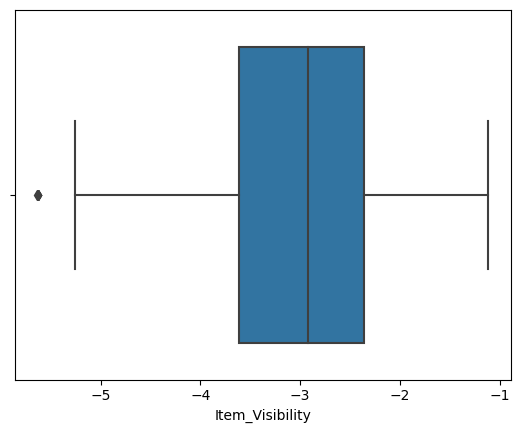

In [12]:
sns.boxplot(x=np.log(bigmart_data_edited['Item_Visibility']))

<AxesSubplot: xlabel='Item_Outlet_Sales'>

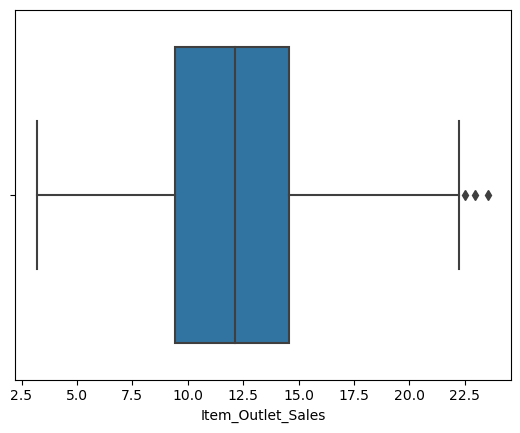

In [13]:
sns.boxplot(x=np.cbrt(bigmart_data_edited['Item_Outlet_Sales']))

# Scaling the data to get rid of Outliers

In [14]:
# Apply the RobustScaler to the selected columns
scaler = RobustScaler()

scaled_train_data = scaler.fit_transform(bigmart_data_edited[numerical_cols])
scaled_test_data = scaler.fit_transform(bigmart_test_data_edited[numerical_cols[0:3]])

# Convert the scaled data back to a DataFrame
scaled_train_data = pd.DataFrame(scaled_train_data, columns=numerical_cols)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=numerical_cols[0:3])

# Concatenate the scaled data with the original DataFrame
X_scaled = pd.concat([scaled_train_data, bigmart_data_edited.drop(numerical_cols, axis=1)],
                     axis=1)
X_test_scaled = pd.concat([scaled_test_data, bigmart_test_data_edited.drop(numerical_cols[0:3], axis=1)],
                          axis=1)

X_scaled.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales Item_Fat_Content  \
0    -0.426009        -0.560443  1.163142           0.856094          low fat   
1    -0.931241        -0.512646 -1.031872          -0.595888          regular   
2     0.799701        -0.549899 -0.015191           0.133627          low fat   
3     1.053812        -0.797844  0.425652          -0.468429          regular   
4    -0.481315        -0.797844 -0.970966          -0.352717          low fat   

               Item_Type Outlet_Identifier  Outlet_Establishment_Year  \
0                  Dairy            OUT049                       1999   
1            Soft Drinks            OUT018                       2009   
2                   Meat            OUT049                       1999   
3  Fruits and Vegetables            OUT010                       1998   
4              Household            OUT013                       1987   

  Outlet_Size Outlet_Location_Type        Outlet_Type  
0      Medium               Tier 1  Supermarket Type1  
1      Medium               Tier 3  Supermarket Type2  
2      Medium               Tier 1  Supermarket Type1  
3      Medium               Tier 3      Grocery Store  
4        High               Tier 3  Supermarket Type1

In [15]:
X_test_scaled.head()

Item_Weight  Item_Visibility  Item_MRP Item_Fat_Content    Item_Type  \
0     1.540195        -0.701481 -0.366243          low fat  Snack Foods   
1    -0.330579        -0.236790 -0.590469          regular        Dairy   
2     0.616078         0.683884  1.095223          low fat       Others   
3    -0.478588        -0.583685  0.148651          low fat  Snack Foods   
4     0.000000         0.970328  1.013098          regular        Dairy   

  Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0            OUT049                       1999      Medium   
1            OUT017                       2007      Medium   
2            OUT010                       1998      Medium   
3            OUT017                       2007      Medium   
4            OUT027                       1985      Medium   

  Outlet_Location_Type        Outlet_Type  
0               Tier 1  Supermarket Type1  
1               Tier 2  Supermarket Type1  
2               Tier 3      Grocery Store  
3               Tier 2  Supermarket Type1  
4               Tier 3  Supermarket Type3

# Encoding the Categorical Features

In [16]:
encoder = OrdinalEncoder()
X_scaled[categorical_cols] = encoder.fit_transform(
                                            X_scaled[categorical_cols])

X_test_scaled[categorical_cols] = encoder.fit_transform(
                                            X_test_scaled[categorical_cols])

X_scaled.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales  \
0    -0.426009        -0.560443  1.163142           0.856094   
1    -0.931241        -0.512646 -1.031872          -0.595888   
2     0.799701        -0.549899 -0.015191           0.133627   
3     1.053812        -0.797844  0.425652          -0.468429   
4    -0.481315        -0.797844 -0.970966          -0.352717   

   Item_Fat_Content  Item_Type  Outlet_Identifier  Outlet_Establishment_Year  \
0               0.0        4.0                9.0                       1999   
1               1.0       14.0                3.0                       2009   
2               0.0       10.0                9.0                       1999   
3               1.0        6.0                0.0                       1998   
4               0.0        9.0                1.0                       1987   

   Outlet_Size  Outlet_Location_Type  Outlet_Type  
0          1.0                   0.0          1.0  
1          1.0                   2.0          2.0  
2          1.0                   0.0          1.0  
3          1.0                   2.0          0.0  
4          0.0                   2.0          1.0

In [17]:
X_test_scaled.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Fat_Content  Item_Type  \
0     1.540195        -0.701481 -0.366243               0.0       13.0   
1    -0.330579        -0.236790 -0.590469               1.0        4.0   
2     0.616078         0.683884  1.095223               0.0       11.0   
3    -0.478588        -0.583685  0.148651               0.0       13.0   
4     0.000000         0.970328  1.013098               1.0        4.0   

   Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  \
0                9.0                       1999          1.0   
1                2.0                       2007          1.0   
2                0.0                       1998          1.0   
3                2.0                       2007          1.0   
4                5.0                       1985          1.0   

   Outlet_Location_Type  Outlet_Type  
0                   0.0          1.0  
1                   1.0          1.0  
2                   2.0          0.0  
3                   1.0          1.0  
4                   2.0          3.0

In [18]:
sns.heatmap(X_scaled.corr(),annot=True)

<AxesSubplot: >

# Modeling

In [19]:
y = X_scaled['Item_Outlet_Sales']
X = X_scaled.drop('Item_Outlet_Sales', axis=1)

#, random_state=99
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

# Linear Regression

In [20]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_test_pred = lr_model.predict(X_test)

print(mean_squared_error(y_test, y_test_pred))
print(mean_absolute_error(y_test, y_test_pred))
print(f'r2_score = {r2_score(y_test, y_test_pred)}')

0.28417759817215027
0.39336805402758734
r2_score = 0.5254321056070277


# Decision Tree Model

In [21]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

y_test_predict1 = dt_model.predict(X_test)

print(mean_squared_error(y_test, y_test_predict1))
print(mean_absolute_error(y_test, y_test_predict1))
print(f'r2_score = {r2_score(y_test, y_test_predict1)}')

0.474531780613532
0.4776999248270132
r2_score = 0.20754644491051455


# Random Forest Model

In [23]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_test_predict3 = rf_model.predict(X_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_test_predict3)}')
print(f'mean_absolute_error = {mean_absolute_error(y_test, y_test_predict3)}')
print(f'r2_score = {r2_score(y_test, y_test_predict3)}')

mean_squared_error = 0.25542067564045234
mean_absolute_error = 0.3506805779763248
r2_score = 0.5734552864026601
